#Import

Install

In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


Import

In [3]:
import datetime 
import requests
import math
import sklearn
import itertools
from itertools import product
from datetime import datetime

import pandas as pd
import numpy as np 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from matplotlib.pylab import rcParams

import pmdarima as pm
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

#Data

In [4]:
df_raw = pd.read_csv('20211022_수요예측_hackathon_data.csv', encoding = 'cp949')
df = df_raw
df

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1.0,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1.0,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1.0,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1.0,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2.0,male,경형
...,...,...,...,...,...,...,...
192140,경기도,남양주시,2019-05-17 20:57:39+00:00,2019-05-17 16:30:00+00:00,1.0,male,준중형SUV
192141,경기도,남양주시,2019-10-13 23:32:28+00:00,2019-10-13 22:00:00+00:00,1.0,male,준중형
192142,경기도,남양주시,2019-06-23 01:42:15+00:00,2019-06-23 01:20:00+00:00,1.0,male,소형SUV
192143,경기도,남양주시,2019-07-14 16:36:30+00:00,2019-07-14 16:00:00+00:00,1.0,male,준중형


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192145 entries, 0 to 192144
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   region1                192145 non-null  object 
 1   region2                192145 non-null  object 
 2   reservation_return_at  192145 non-null  object 
 3   reservation_start_at   192144 non-null  object 
 4   age_group              192144 non-null  float64
 5   gender                 192144 non-null  object 
 6   car_model              192144 non-null  object 
dtypes: float64(1), object(6)
memory usage: 10.3+ MB


In [6]:
df['reservation_return_at'] = pd.to_datetime(df['reservation_return_at'])
df['reservation_start_at'] = pd.to_datetime(df['reservation_start_at'])

In [7]:
df.isnull().sum()

region1                  0
region2                  0
reservation_return_at    0
reservation_start_at     1
age_group                1
gender                   1
car_model                1
dtype: int64

In [8]:
df.dropna(axis = 0, inplace = True)

In [9]:
df_경기도 = df[df['region1'] == '경기도']
df_경기도

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1.0,male,소형SUV
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4.0,male,준중형SUV
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1.0,male,소형SUV
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3.0,female,소형SUV
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2.0,male,준중형
...,...,...,...,...,...,...,...
192139,경기도,남양주시,2019-05-19 13:32:19+00:00,2019-05-19 12:20:00+00:00,1.0,male,준중형
192140,경기도,남양주시,2019-05-17 20:57:39+00:00,2019-05-17 16:30:00+00:00,1.0,male,준중형SUV
192141,경기도,남양주시,2019-10-13 23:32:28+00:00,2019-10-13 22:00:00+00:00,1.0,male,준중형
192142,경기도,남양주시,2019-06-23 01:42:15+00:00,2019-06-23 01:20:00+00:00,1.0,male,소형SUV


In [10]:
df_경기도['used_time'] = df_경기도['reservation_return_at'] - df_경기도['reservation_start_at']
df_경기도['reservation_return_date'] = df_경기도['reservation_return_at'].dt.to_period(freq = 'D')
df_경기도['reservation_start_date'] = df_경기도['reservation_start_at'].dt.to_period(freq = 'D')
df_경기도['week'] = df_경기도['reservation_start_date'].dt.dayofweek

In [11]:
df_경기도

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1.0,male,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4.0,male,준중형SUV,0 days 23:50:00,2019-05-14,2019-05-13,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1.0,male,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3.0,female,소형SUV,0 days 09:24:19,2019-04-07,2019-04-07,6
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2.0,male,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4
...,...,...,...,...,...,...,...,...,...,...,...
192139,경기도,남양주시,2019-05-19 13:32:19+00:00,2019-05-19 12:20:00+00:00,1.0,male,준중형,0 days 01:12:19,2019-05-19,2019-05-19,6
192140,경기도,남양주시,2019-05-17 20:57:39+00:00,2019-05-17 16:30:00+00:00,1.0,male,준중형SUV,0 days 04:27:39,2019-05-17,2019-05-17,4
192141,경기도,남양주시,2019-10-13 23:32:28+00:00,2019-10-13 22:00:00+00:00,1.0,male,준중형,0 days 01:32:28,2019-10-13,2019-10-13,6
192142,경기도,남양주시,2019-06-23 01:42:15+00:00,2019-06-23 01:20:00+00:00,1.0,male,소형SUV,0 days 00:22:15,2019-06-23,2019-06-23,6


In [12]:
df_경기도['gender'] = df_경기도['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_경기도['is_weekend'] = df_경기도['week'].apply(lambda x: 0 if x < 5 else 1)
df_경기도 = df_경기도[df_경기도['age_group'] < 3]
df_경기도

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week,is_weekend
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1.0,0,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1.0,0,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4,0
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2.0,0,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4,0
44110,경기도,광명시,2019-03-31 01:59:40+00:00,2019-03-30 21:30:00+00:00,2.0,1,소형SUV,0 days 04:29:40,2019-03-31,2019-03-30,5,1
44111,경기도,광명시,2019-09-20 12:39:13+00:00,2019-09-20 09:10:00+00:00,2.0,1,준중형,0 days 03:29:13,2019-09-20,2019-09-20,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
192139,경기도,남양주시,2019-05-19 13:32:19+00:00,2019-05-19 12:20:00+00:00,1.0,0,준중형,0 days 01:12:19,2019-05-19,2019-05-19,6,1
192140,경기도,남양주시,2019-05-17 20:57:39+00:00,2019-05-17 16:30:00+00:00,1.0,0,준중형SUV,0 days 04:27:39,2019-05-17,2019-05-17,4,0
192141,경기도,남양주시,2019-10-13 23:32:28+00:00,2019-10-13 22:00:00+00:00,1.0,0,준중형,0 days 01:32:28,2019-10-13,2019-10-13,6,1
192142,경기도,남양주시,2019-06-23 01:42:15+00:00,2019-06-23 01:20:00+00:00,1.0,0,소형SUV,0 days 00:22:15,2019-06-23,2019-06-23,6,1


In [13]:
df_경기도['region2'].unique()

array(['광명시', '구리시', '김포시', '양평군', '하남시', '화성시', '남양주시'], dtype=object)

#함수

In [14]:
def plot_rolling_statistics(timeseries, window = 12):
    rolmean = timeseries.rolling(window = window).mean()
    rolstd = timeseries.rolling(window = window).std()

    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

In [15]:
def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag = 'AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

In [16]:
def sarima(data):
    df_function = pd.DataFrame(data['reservation_start_date'].value_counts())
    df_function.reset_index(inplace = True)
    df_function.columns = ['Date', 'Demand']
    df_function.sort_values(by = ['Date'], inplace = True)
    df_function['Date'] = df_function['Date'].astype(str)
    df_function.set_index('Date', inplace = True)

    ts = df_function['Demand']
    plot_rolling_statistics(ts, window = 12)
    augmented_dickey_fuller_test(ts)

    decomposition = seasonal_decompose(ts, model = 'multiplicative', period = 30)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label = 'Original')
    plt.legend(loc = 'best')
    plt.subplot(412)
    plt.plot(trend, label = 'Trend')
    plt.legend(loc = 'best')
    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonal')
    plt.legend(loc = 'best')
    plt.subplot(414)
    plt.plot(residual, label = 'Residuals') 
    plt.legend(loc = 'best')
    plt.tight_layout()

    residual.dropna(inplace = True)
    augmented_dickey_fuller_test(residual)

    train_data, test_data = ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]
    plt.figure(figsize = (10, 6))
    plt.plot(ts, c = 'r', label = 'training dataset')
    plt.plot(test_data, c = 'b', label = 'test dataset')
    plt.legend()

    plot_acf(ts)
    plot_pacf(ts)
    plt.show()

    diff_1 = ts.diff(periods = 1).iloc[1:]
    diff_1.plot(title = 'Difference 1st')
    augmented_dickey_fuller_test(diff_1)

    model = pm.auto_arima(train_data, seasonal = True, m = 7, D = 1)
    print(model)
    print(model.params())
    print(model.aic())

    sarima_pred, conf_int = model.predict(n_periods = test_data.shape[0], return_conf_int = True)
    sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(test_data, sarima_pred))
    print(f'Test RMSE: {sarima_rmse}\n')
    print(f'MSE: {sarima_rmse**2}\n')

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
    plt.xticks(rotation = 45)
    loc = plticker.MultipleLocator(base = 7.0) 
    ax.xaxis.set_major_locator(loc)

    plt.plot(train_data[-50:], alpha = 0.5, color = 'black', label = 'training')
    plt.plot(test_data, alpha = 0.5, color = 'red', label = 'actual demand')
    plt.plot(test_data.index.values, sarima_pred, alpha = 0.5, color = 'blue', label = 'predicted demand')
    plt.fill_between(test_data.index.values, conf_int[:, 0], conf_int[:, 1], alpha = 0.1, color = 'b') 
    plt.legend()
    plt.show()

    model.plot_diagnostics(figsize=(10, 10))
    plt.show()  

#분석

A 지역

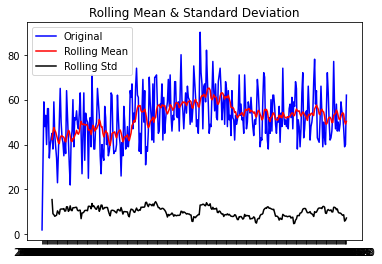

Results of Dickey-Fuller Test:
Test Statistic                  -2.224925
p-value                          0.197324
#Lags Used                      13.000000
Number of Observations Used    322.000000
Critical Value (1%)             -3.450823
Critical Value (5%)             -2.870558
Critical Value (10%)            -2.571575
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.872169e+00
p-value                        4.951669e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.890000e+02
Critical Value (1%)           -3.453182e+00
Critical Value (5%)           -2.871593e+00
Critical Value (10%)          -2.572127e+00
dtype: float64


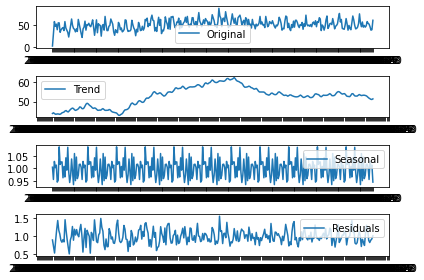

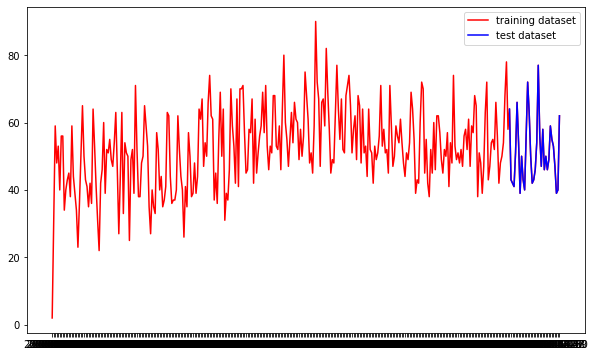

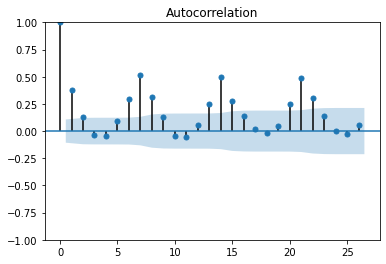

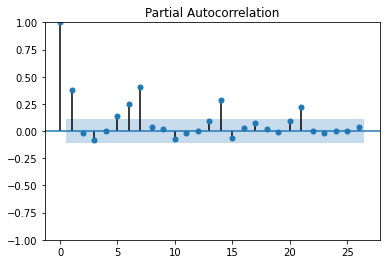

Results of Dickey-Fuller Test:
Test Statistic                -9.550903e+00
p-value                        2.573559e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.220000e+02
Critical Value (1%)           -3.450823e+00
Critical Value (5%)           -2.870558e+00
Critical Value (10%)          -2.571575e+00
dtype: float64
 ARIMA(2,0,1)(0,1,1)[7]          
ar.L1       1.141797
ar.L2      -0.152488
ma.L1      -0.936605
ma.S.L7    -0.862125
sigma2     74.126937
dtype: float64
2126.0052812259164
Test RMSE: 7.945829422683405

MSE: 63.1362052143813



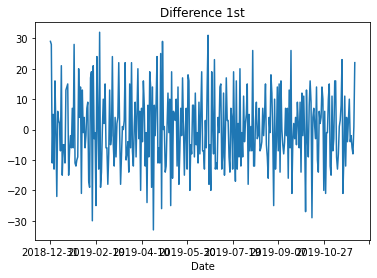

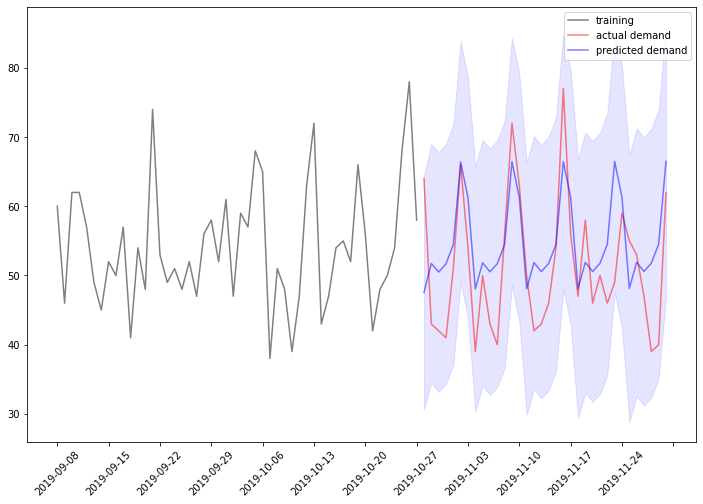

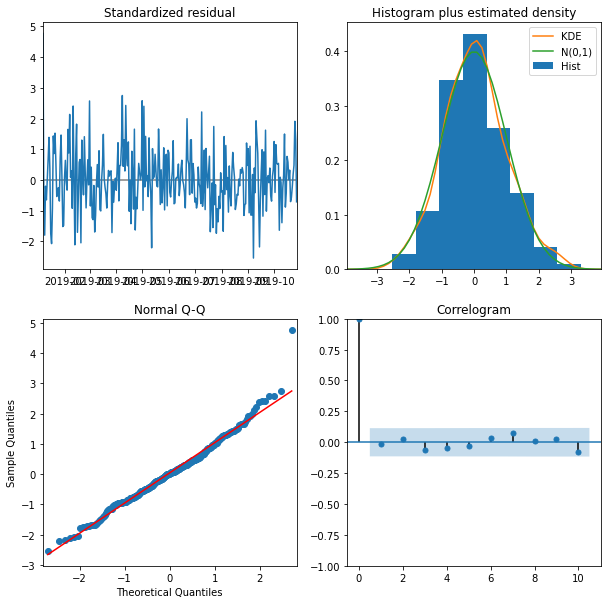

In [17]:
df_A = df_경기도[(df_경기도['region2'] == '김포시') | (df_경기도['region2'] == '의정부시') | (df_경기도['region2'] == '고양시\u3000덕양구') | (df_경기도['region2'] == '성남시\u3000분당구')]
sarima(df_A)

B 지역

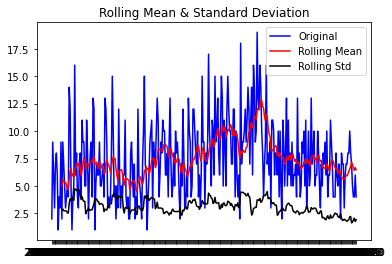

Results of Dickey-Fuller Test:
Test Statistic                  -2.124937
p-value                          0.234606
#Lags Used                      14.000000
Number of Observations Used    318.000000
Critical Value (1%)             -3.451082
Critical Value (5%)             -2.870672
Critical Value (10%)            -2.571636
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.014651
p-value                          0.000021
#Lags Used                      13.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


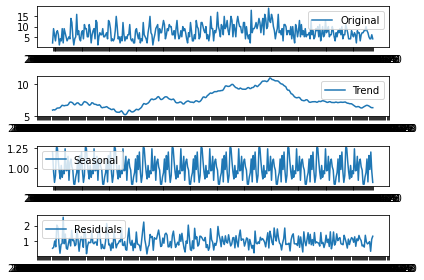

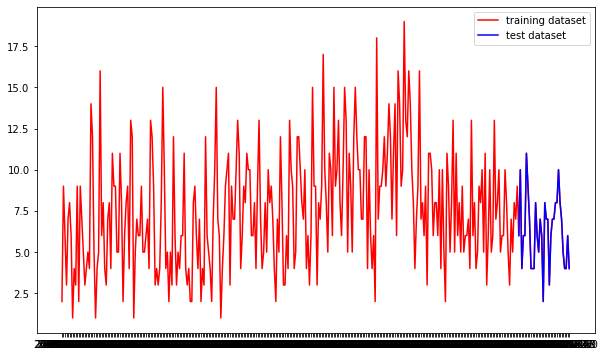

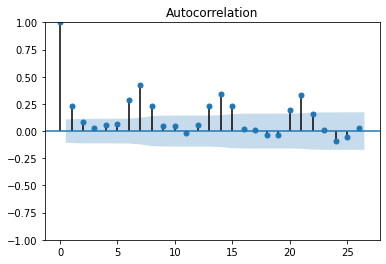

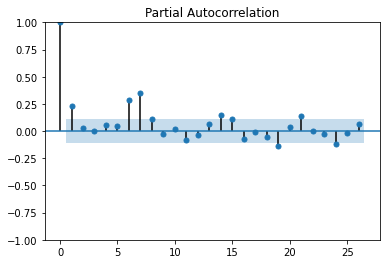

Results of Dickey-Fuller Test:
Test Statistic                -8.095538e+00
p-value                        1.342230e-12
#Lags Used                     1.300000e+01
Number of Observations Used    3.180000e+02
Critical Value (1%)           -3.451082e+00
Critical Value (5%)           -2.870672e+00
Critical Value (10%)          -2.571636e+00
dtype: float64
 ARIMA(0,0,0)(0,1,2)[7]          
ma.S.L7    -0.682585
ma.S.L14   -0.099668
sigma2      9.613356
dtype: float64
1501.6294158410299
Test RMSE: 2.602680102060023

MSE: 6.773943713659172



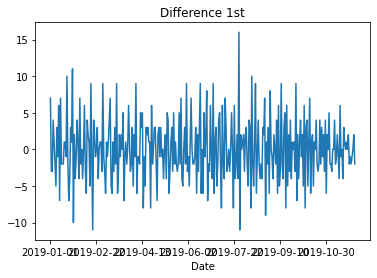

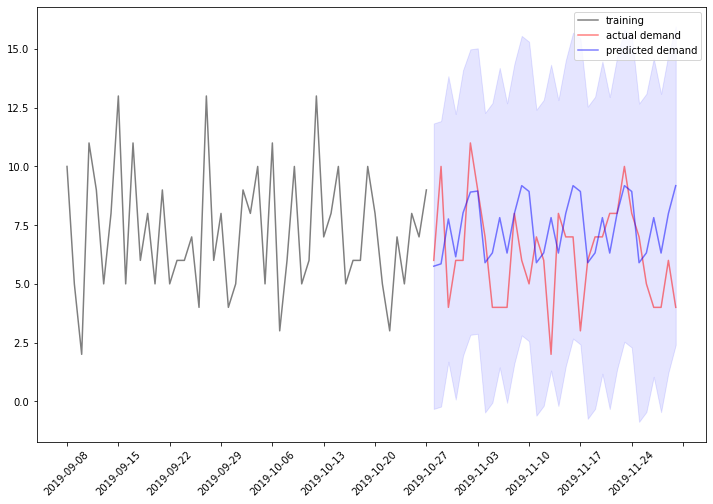

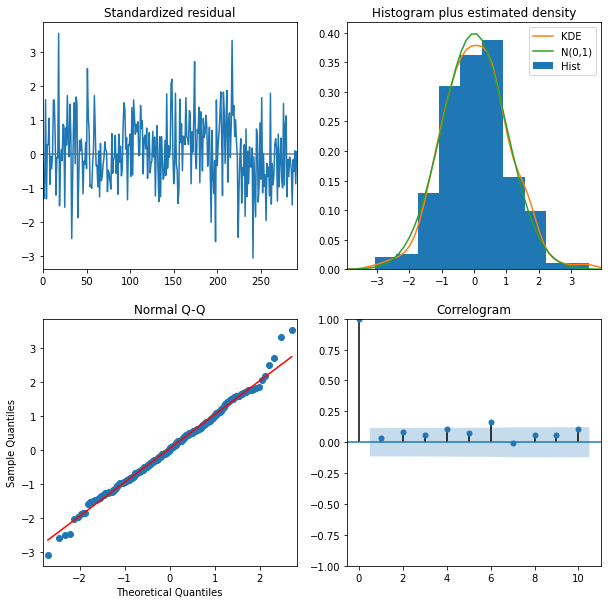

In [18]:
df_B = df_경기도[df_경기도['region2'] == '양평군']
sarima(df_B)

C 지역

D 지역

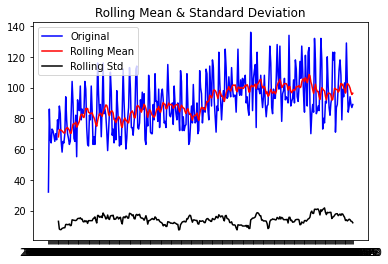

Results of Dickey-Fuller Test:
Test Statistic                  -2.036612
p-value                          0.270754
#Lags Used                      13.000000
Number of Observations Used    321.000000
Critical Value (1%)             -3.450887
Critical Value (5%)             -2.870586
Critical Value (10%)            -2.571590
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.998488e+00
p-value                        7.426632e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.880000e+02
Critical Value (1%)           -3.453262e+00
Critical Value (5%)           -2.871628e+00
Critical Value (10%)          -2.572146e+00
dtype: float64


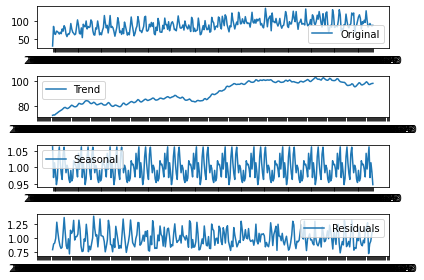

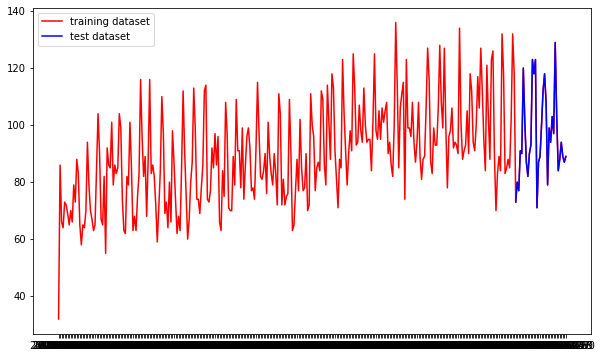

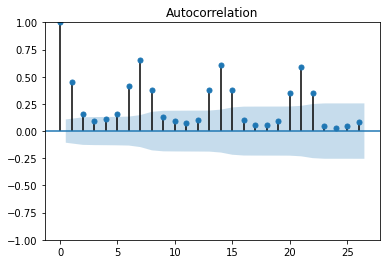

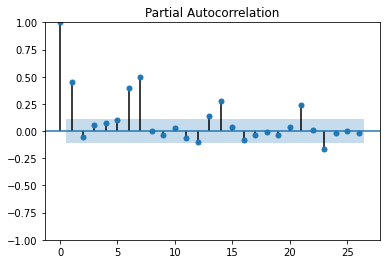

Results of Dickey-Fuller Test:
Test Statistic                -9.023028e+00
p-value                        5.707255e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.210000e+02
Critical Value (1%)           -3.450887e+00
Critical Value (5%)           -2.870586e+00
Critical Value (10%)          -2.571590e+00
dtype: float64
 ARIMA(1,0,0)(0,1,1)[7] intercept
intercept      0.591055
ar.L1          0.187211
ma.S.L7       -0.905037
sigma2       106.677365
dtype: float64
2227.2691257460388
Test RMSE: 15.216353255088553

MSE: 231.537406383644



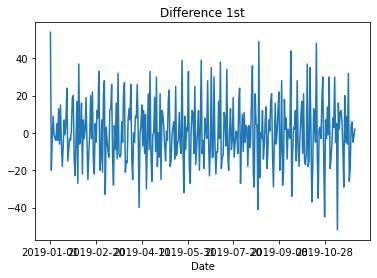

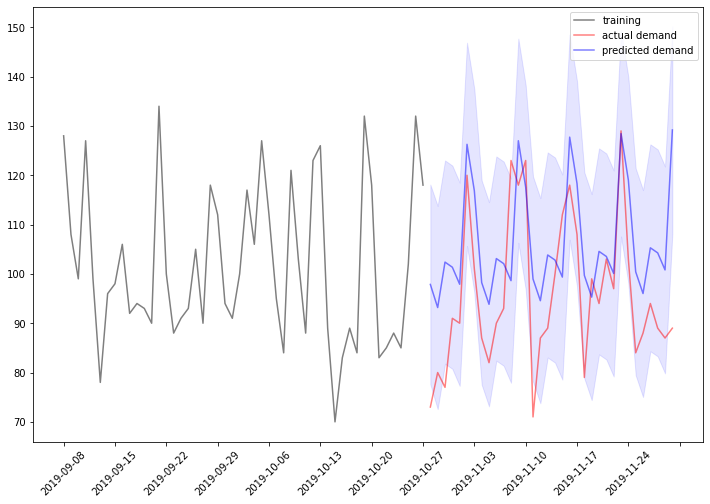

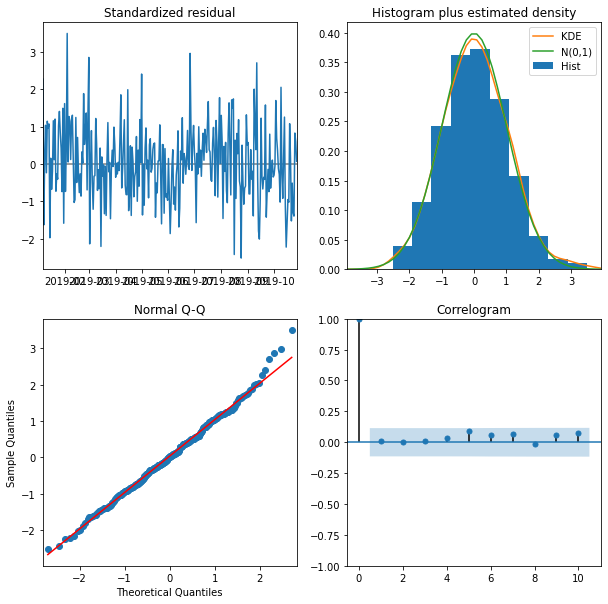

In [19]:
df_D = df_경기도[(df_경기도['region2'] == '광명시') | (df_경기도['region2'] == '하남시') | (df_경기도['region2'] == '안양시\u3000동안구') | (df_경기도['region2'] == '고양시\u3000일산동구') | (df_경기도['region2'] == '고양시\u3000일산서구')]
sarima(df_D)

E 지역

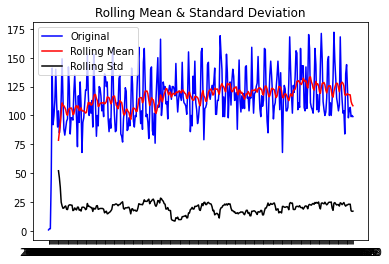

Results of Dickey-Fuller Test:
Test Statistic                  -3.205072
p-value                          0.019693
#Lags Used                      13.000000
Number of Observations Used    324.000000
Critical Value (1%)             -3.450695
Critical Value (5%)             -2.870502
Critical Value (10%)            -2.571545
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.341343e+00
p-value                        3.170005e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.960000e+02
Critical Value (1%)           -3.452637e+00
Critical Value (5%)           -2.871354e+00
Critical Value (10%)          -2.571999e+00
dtype: float64


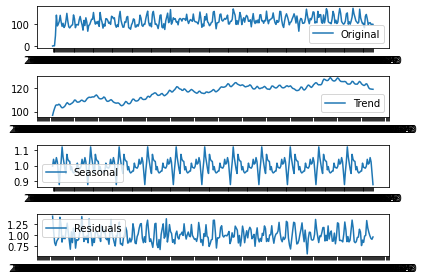

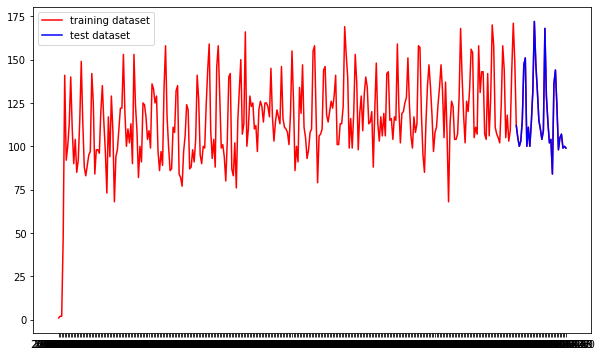

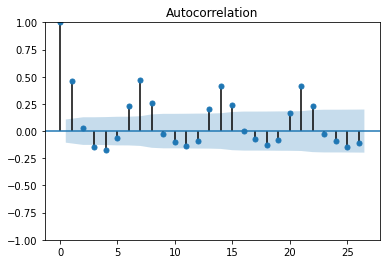

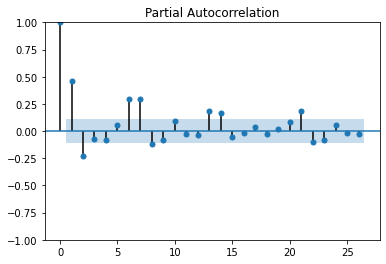

Results of Dickey-Fuller Test:
Test Statistic                -8.650905e+00
p-value                        5.118675e-14
#Lags Used                     1.200000e+01
Number of Observations Used    3.240000e+02
Critical Value (1%)           -3.450695e+00
Critical Value (5%)           -2.870502e+00
Critical Value (10%)          -2.571545e+00
dtype: float64
 ARIMA(1,0,0)(1,1,2)[7]          
ar.L1         0.477069
ar.S.L7      -0.811392
ma.S.L7       0.048372
ma.S.L14     -0.803746
sigma2      288.598321
dtype: float64
2546.3474546176903
Test RMSE: 15.608830853827937

MSE: 243.63560062341097



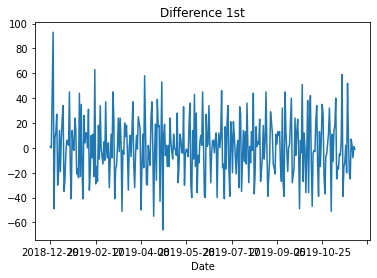

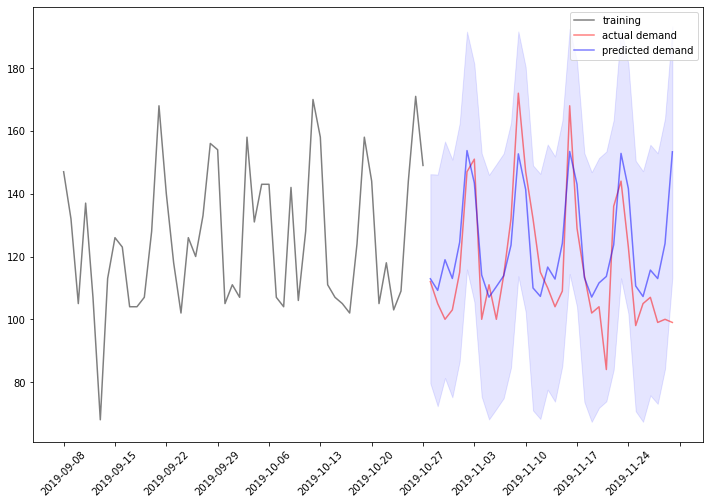

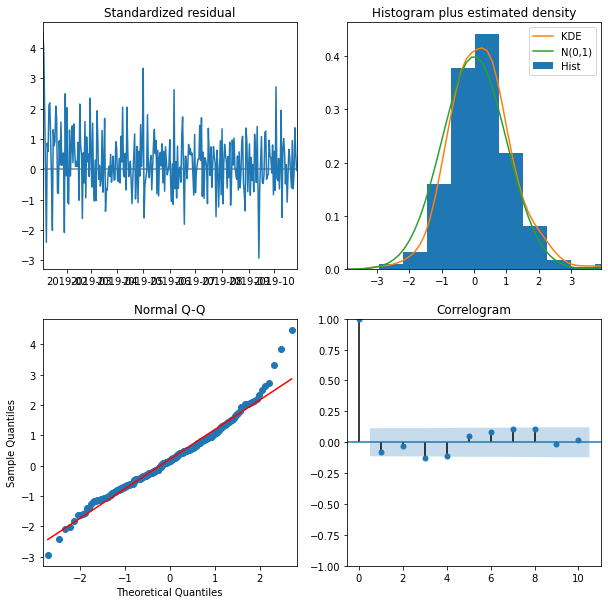

In [20]:
df_E = df_경기도[(df_경기도['region2'] == '화성시') | (df_경기도['region2'] == '남양주시')]
sarima(df_E)

F 지역

G 지역

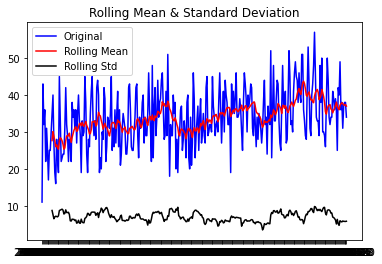

Results of Dickey-Fuller Test:
Test Statistic                  -2.027566
p-value                          0.274619
#Lags Used                      14.000000
Number of Observations Used    320.000000
Critical Value (1%)             -3.450952
Critical Value (5%)             -2.870615
Critical Value (10%)            -2.571605
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.863424e+00
p-value                        1.581135e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.910000e+02
Critical Value (1%)           -3.453023e+00
Critical Value (5%)           -2.871524e+00
Critical Value (10%)          -2.572090e+00
dtype: float64


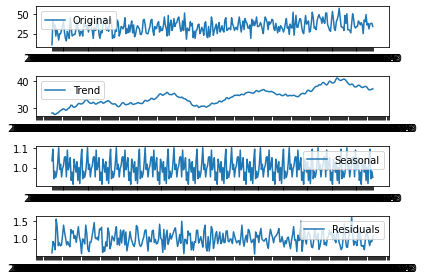

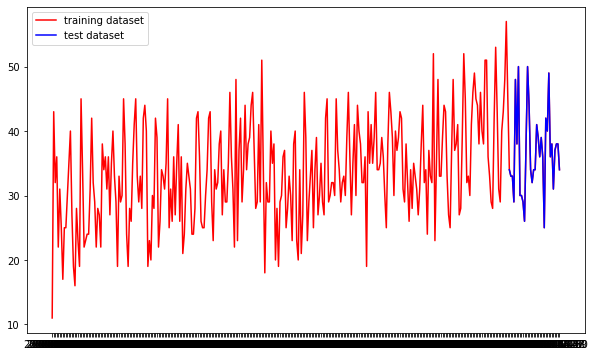

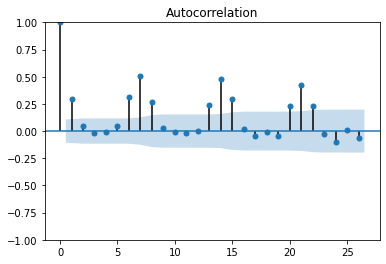

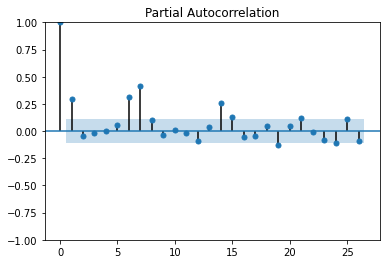

Results of Dickey-Fuller Test:
Test Statistic                -9.086284e+00
p-value                        3.932295e-15
#Lags Used                     1.300000e+01
Number of Observations Used    3.200000e+02
Critical Value (1%)           -3.450952e+00
Critical Value (5%)           -2.870615e+00
Critical Value (10%)          -2.571605e+00
dtype: float64
 ARIMA(0,0,0)(2,1,0)[7] intercept
intercept     0.600348
ar.S.L7      -0.614236
ar.S.L14     -0.307879
sigma2       41.024862
dtype: float64
1937.4480157844382
Test RMSE: 8.112069810974605

MSE: 65.80567661812556



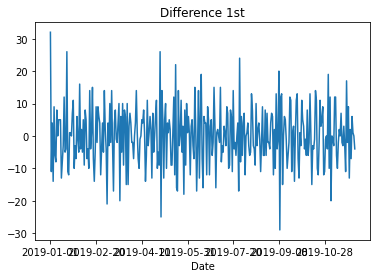

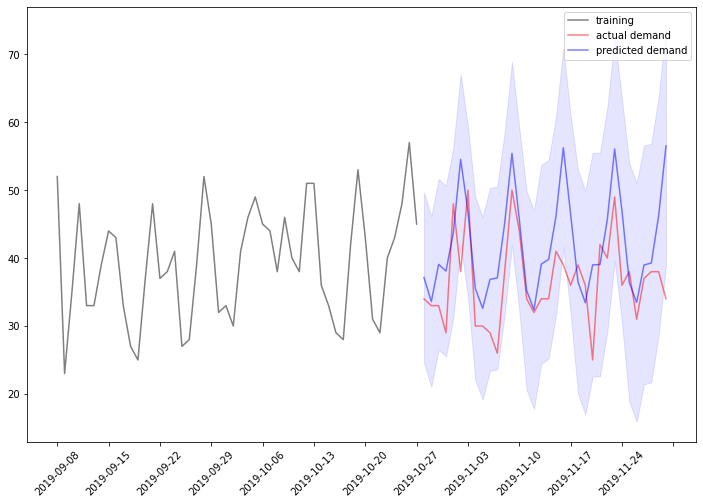

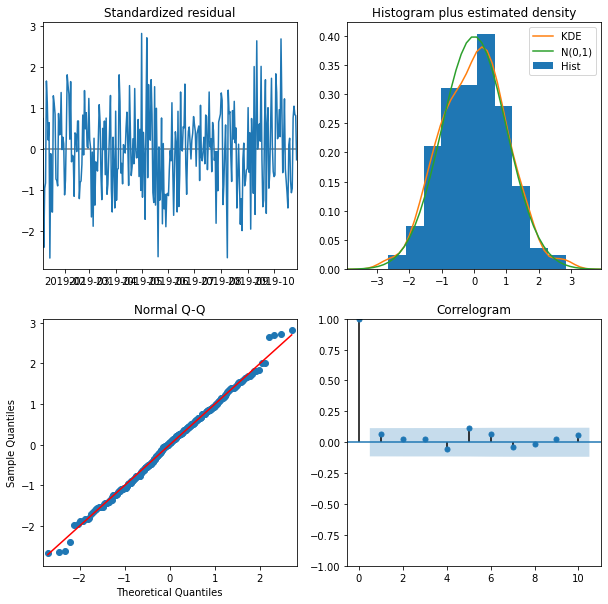

In [22]:
df_G = df_경기도[(df_경기도['region2'] == '구리시') | (df_경기도['region2'] == '성남시\u3000수정구') | (df_경기도['region2'] == '성남시\u3000중원구') | (df_경기도['region2'] == '안양시\u3000만안구')]
sarima(df_G)